In [31]:
import tensorflow as tf
import keras
import math

In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import time
import pickle as pkl

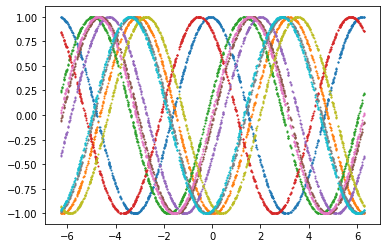

In [34]:
seed = 1
np.random.seed(seed)

cell_time = np.random.uniform(-2 * np.pi, 2 * np.pi, [1000, 1])

gene01_phase = np.random.uniform(0, 2 * np.pi, [1, 500])
gene01_time = np.random.normal(0, 0.1, [1, 500])
gene01_speed = np.random.uniform(0.5, 1.5, [1, 500])

gene0_phase = np.random.uniform(0, 2 * np.pi, [1, 800])

gene1_time = np.random.normal(0, 0.1, [1, 500])
gene1_speed = np.random.uniform(0.5, 1.5, [1, 500])

gene0 = np.sin(cell_time - gene0_phase)
gene1 = np.tanh(gene1_speed * (cell_time - gene1_time))
gene01 = np.sin(cell_time - gene01_phase) + np.tanh(gene01_speed * (cell_time - gene01_time))

for i in range(10):
    plt.scatter(x=cell_time, y=gene0[:, i], s=1)

In [35]:
gene0.shape

(1000, 800)

In [36]:
y = keras.Input(shape=(gene0.shape[1],), name='input')
x = keras.layers.Dense(units=50, 
                       kernel_regularizer=keras.regularizers.l2(0.0001),
                       kernel_initializer=keras.initializers.glorot_normal(seed=2018)
                      )(y)
x = keras.layers.Activation(activation='tanh')(x)

x = keras.layers.Dense(units=30,
                       kernel_regularizer=keras.regularizers.l2(0.0001),
                       kernel_initializer=keras.initializers.glorot_normal(seed=2019)
                      )(x)
x = keras.layers.Activation(activation='tanh')(x)

x = keras.layers.Dense(units=1, 
                       use_bias=False, 
                       kernel_regularizer=keras.regularizers.l2(0.00001),
                       kernel_initializer=keras.initializers.glorot_normal(seed=2020),
                       name='neck'
                      )(x)

x0 = keras.layers.Lambda(lambda x: keras.backend.sin(x), name='phase0')(x)
x1 = keras.layers.Lambda(lambda x: keras.backend.cos(x), name='phase1')(x)
x = keras.layers.Concatenate(name='stack')([x0, x1])

x = keras.layers.Dense(gene0.shape[1], 
                       use_bias=False,
                       kernel_regularizer=None,
                       kernel_initializer=keras.initializers.Zeros(),
                       name='reconstructed'
                       )(x)

model = keras.Model(outputs=x, inputs=y)

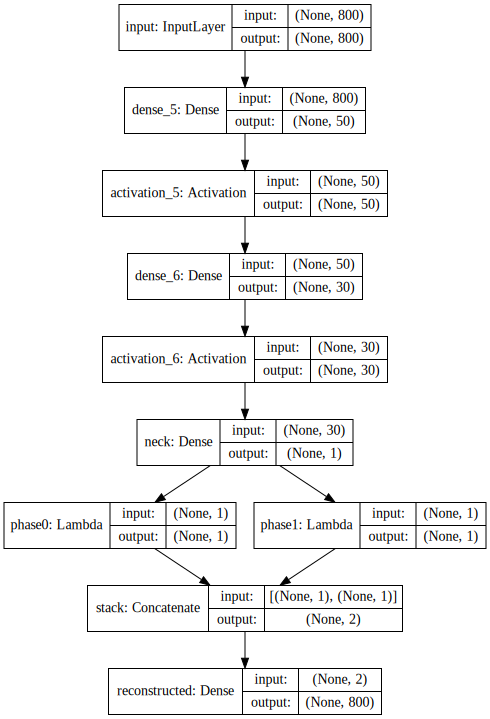

In [37]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [38]:
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(1e-3))

class MyCallback(keras.callbacks.Callback):
    def __init__(self, interval = 100):
        self.cnt = 0
        self.interval = interval
        self.start_time = 0
        self.rec = {'time': [], 'loss': []}
    
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    
    def on_epoch_end(self, batch, logs={}):
        self.cnt += 1
        self.rec['time'].append(time.time() - self.start_time)
        self.rec['loss'].append(logs.get('loss'))
        if self.cnt % self.interval == 0:
            print(f'epoch: {self.cnt}/{self.params["epochs"]}, loss: {logs.get("loss") : .4f}, total train time: {self.rec["time"][-1] : .2f}s')

my_callback = MyCallback()
history = model.fit(gene0, gene0, epochs=3000, verbose=0, callbacks=[my_callback])

epoch: 100/3000, loss:  0.0099, total train time:  9.97s
epoch: 200/3000, loss:  0.0111, total train time:  19.18s
epoch: 300/3000, loss:  0.0051, total train time:  28.91s
epoch: 400/3000, loss:  0.0081, total train time:  38.53s
epoch: 500/3000, loss:  0.0039, total train time:  48.29s
epoch: 600/3000, loss:  0.0038, total train time:  58.30s
epoch: 700/3000, loss:  0.0185, total train time:  68.22s
epoch: 800/3000, loss:  0.0111, total train time:  78.04s
epoch: 900/3000, loss:  0.0144, total train time:  88.29s
epoch: 1000/3000, loss:  0.0039, total train time:  97.18s
epoch: 1100/3000, loss:  0.0097, total train time:  107.36s
epoch: 1200/3000, loss:  0.0037, total train time:  117.54s
epoch: 1300/3000, loss:  0.0024, total train time:  127.59s
epoch: 1400/3000, loss:  0.0032, total train time:  138.02s
epoch: 1500/3000, loss:  0.0031, total train time:  148.07s
epoch: 1600/3000, loss:  0.0036, total train time:  158.14s
epoch: 1700/3000, loss:  0.0037, total train time:  168.32s


In [39]:
#model.compile(loss='mean_squared_error', 
#              optimizer=keras.optimizers.Adam(1e-4, epsilon=1e-4))
#history = model.fit(gene0, gene0, epochs=5000, verbose=2)


In [40]:
model.evaluate(x=gene0, y=gene0)

1000/1000 [==============================] - 0s 84us/step


0.003630771715193987

In [41]:
model.get_layer('neck')

In [42]:
res = keras.backend.function([model.layers[0].input], 
                             [model.get_layer('neck').output, model.get_layer('reconstructed').output]
                            )([gene0])

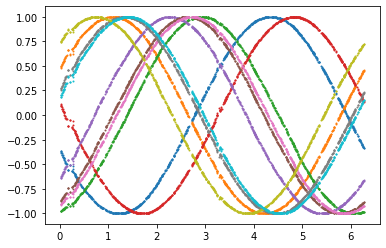

In [43]:
for i in range(10):
    plt.scatter(x=res[0] % (2 * np.pi), y=gene0[:, i], s=1)

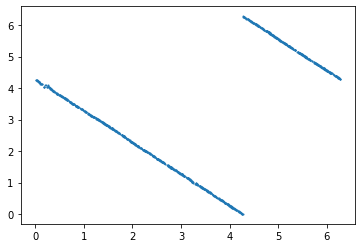

In [44]:
plt.scatter(res[0] % (2 * np.pi), cell_time % (2 * np.pi), s = 1)

In [45]:
with open('comp-2-tanh-glorot-norm-seed-%d.pkl' % seed, 'wb') as file:
    pkl.dump(my_callback.rec, file)



